In [1]:
from __future__ import annotations
from dataclasses import dataclass
from datetime import datetime
from typing import List, Tuple, Iterable, Optional, Dict, Any
import re
import json
import csv
from pathlib import Path

In [2]:
@dataclass(frozen=True)
class Operation:
    op_type: str            # 'deposit'|'withdraw'|'init'|'interest'
    amount: float
    timestamp: datetime
    balance_after: float
    status: str             # 'success'|'fail'
    note: str = ""

In [ ]:
class Account:

    _account_counter: int = 1000

    # --- валидация имени ---
    _NAME_RE = re.compile(
        r'^(?:[A-Z][a-z]+|[А-ЯЁ][а-яё]+)\s(?:[A-Z][a-z]+|[А-ЯЁ][а-яё]+)$'
    )

    @staticmethod
    def _validate_holder(holder: str) -> str:
        if not isinstance(holder, str) or not holder.strip():
            raise ValueError("Имя владельца должно быть непустой строкой.")
        holder = holder.strip()
        if not Account._NAME_RE.fullmatch(holder):
            raise ValueError("Имя владельца должно быть в формате «Имя Фамилия» с заглавных букв.")
        return holder

    def __init__(self, account_holder: str, balance: float = 0.0, account_number: Optional[str] = None) -> None:
        if balance < 0:
            raise ValueError("Начальный баланс не может быть отрицательным.")
        self.holder: str = self._validate_holder(account_holder)
        if account_number:
            if not re.fullmatch(r'ACC-\d{6}', account_number) and not re.fullmatch(r'ACC-\d{4}', account_number):
                raise ValueError("account_number должен быть в формате 'ACC-XXXX' или 'ACC-XXXXXX'.")
            self.account_number = account_number
        else:
            self.account_number: str = f"ACC-{Account._account_counter:04d}"
            Account._account_counter += 1
        self._balance: float = float(balance)
        self.operations_history: List[Operation] = []
        self._log("init", self._balance, "success", "Инициализация счёта")

    # --- Вспомогательное ---
    def _now(self) -> datetime:
        return datetime.now()

    def _log(self, op_type: str, amount: float, status: str, note: str = "", timestamp: Optional[datetime] = None) -> None:
        self.operations_history.append(
            Operation(
                op_type=op_type,
                amount=float(amount),
                timestamp=timestamp or self._now(),
                balance_after=self._balance,
                status=status,
                note=note,
            )
        )

    # --- Базовые операции ---
    def deposit(self, amount: float, timestamp: Optional[datetime] = None) -> None:
        if amount is None or amount <= 0:
            raise ValueError("Сумма пополнения должна быть положительной (> 0).")
        self._balance += float(amount)
        self._log("deposit", amount, "success", timestamp=timestamp)

    def withdraw(self, amount: float, timestamp: Optional[datetime] = None) -> bool:
        if amount is None or amount <= 0:
            raise ValueError("Сумма снятия должна быть положительной (> 0).")
        if amount > self._balance:
            self._log("withdraw", amount, "fail", "Недостаточно средств", timestamp=timestamp)
            return False
        self._balance -= float(amount)
        self._log("withdraw", amount, "success", timestamp=timestamp)
        return True

    def get_balance(self) -> float:
        return self._balance

    def get_history(self) -> Tuple[Operation, ...]:
        return tuple(self.operations_history)

    # --- Парсинг и очистка ---
    @staticmethod
    def _parse_date(s: Any) -> Optional[datetime]:
        if s is None:
            return None
        if isinstance(s, datetime):
            return s
        s = str(s).strip()
        fmts = [
            "%Y-%m-%d %H:%M:%S",   # 2025-10-01 22:17:26
            "%d/%m/%Y %H:%M",      # 06/10/2025 22:17
            "%Y/%m/%d %H:%M:%S",   # на всякий пожарный
        ]
        for fmt in fmts:
            try:
                return datetime.strptime(s, fmt)
            except ValueError:
                continue
        return None  # недопустимая дата

    @classmethod
    def _normalize_operation(cls, op: Any) -> Optional[str]:
        if op is None:
            return None
        s = str(op).strip().lower()
        mapping = {
            "deposit": "deposit",
            "diposit": "deposit",
            "dep": "deposit",
            "withdraw": "withdraw",
            "wdraw": "withdraw",
            "wd": "withdraw",
            "interest": "interest",
            "intr": "interest",
        }
        return mapping.get(s)

    @classmethod
    def allowed_operations(cls) -> set[str]:
        # базовый класс позволяет deposit/withdraw по умолчанию; переопределение подклассом
        return {"deposit", "withdraw"}

    def clean_history(self, records: Iterable[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Канонезависимая очистка входных записей.
        Возвращает список словарей: {'timestamp','operation','amount'} для текущего аккаунта.
        Правила:
          - Фильтруем по account_number совпадающему self.account_number.
          - Нормализуем operation (фиксируем опечатки).
          - Проверяем, что операция входит в allowed_operations.
          - amount > 0 и не None.
          - Корректные даты (с поддержкой нескольких форматов).
          - Дубликаты удаляются по ключу (timestamp, operation, amount).
          - Статус из файла игнорируется; будем применять бизнес-правила при записи.
        """
        allowed = self.allowed_operations()
        cleaned: List[Dict[str, Any]] = []
        seen: set[tuple] = set()

        for rec in records:
            try:
                if str(rec.get("account_number", "")).strip() != self.account_number:
                    continue
                op = self._normalize_operation(rec.get("operation"))
                if op is None or op not in allowed:
                    continue
                amount = rec.get("amount")
                if amount is None:
                    continue
                try:
                    amount = float(amount)
                except (TypeError, ValueError):
                    continue
                if amount <= 0:
                    continue
                ts = self._parse_date(rec.get("date"))
                if ts is None:
                    continue

                key = (ts, op, round(amount, 2))
                if key in seen:
                    continue
                seen.add(key)
                cleaned.append({"timestamp": ts, "operation": op, "amount": amount})
            except Exception:
                # тихий пропуск битых записей
                continue

        cleaned.sort(key=lambda r: r["timestamp"])  # хронологический
        return cleaned

    # --- загрузка из файла ---
    @staticmethod
    def _read_file(path: str | Path) -> List[Dict[str, Any]]:
        p = Path(path)
        if not p.exists():
            raise FileNotFoundError(f"Файл не найден: {p}")
        if p.suffix.lower() == ".json":
            return json.loads(p.read_text(encoding="utf-8"))
        elif p.suffix.lower() == ".csv":
            with p.open("r", encoding="utf-8", newline="") as f:
                reader = csv.DictReader(f)
                return list(reader)
        else:
            raise ValueError("Поддерживаются только .csv и .json")

    def load_history_from_file(self, path: str | Path) -> None:
        """
        Загружает транзакции из файла, очищает их и применяет к текущему аккаунту,
        строго соблюдая бизнес-правила класса (deposit/withdraw ограничения и т.п.).
        Баланс обновляется по мере применения.
        """
        raw = self._read_file(path)
        cleaned = self.clean_history(raw)
        for row in cleaned:
            op = row["operation"]
            amount = row["amount"]
            ts = row["timestamp"]
            if op == "deposit":
                try:
                    self.deposit(amount, timestamp=ts)
                except ValueError as e:
                    self._log("deposit", amount, "fail", f"reject: {e}", timestamp=ts)
            elif op == "withdraw":
                try:
                    ok = self.withdraw(amount, timestamp=ts)
                    # для withdraw уже ведётся логирование успеха/неудачи
                except ValueError as e:
                    self._log("withdraw", amount, "fail", f"reject: {e}", timestamp=ts)
            else:
                # базовый класс не поддерживает начисление процентов; подклассы могут переопределить поведение
                self._log(op, amount, "fail", "Операция не поддерживается текущим типом счёта", timestamp=ts)

    # --- Визуализация ---
    def to_dataframe(self):
        import pandas as pd
        data = [{
            "op_type": op.op_type,
            "amount": op.amount,
            "timestamp": op.timestamp,
            "balance_after": op.balance_after,
            "status": op.status,
            "note": op.note,
        } for op in self.operations_history]
        return pd.DataFrame(data).sort_values("timestamp").reset_index(drop=True)
    
    def plot_history(self, title: str | None = None):
        try:
            import pandas as pd
            import matplotlib.pyplot as plt
        except ImportError as e:
            raise RuntimeError("Для plot_history требуются pandas и matplotlib.") from e
        df = self.to_dataframe()
        if df.empty:
            raise RuntimeError("История пуста — нечего визуализировать.")
        df = df.sort_values("timestamp").reset_index(drop=True)
        plt.figure()
        plt.plot(df["timestamp"], df["balance_after"], marker="o")
        plt.title(title or f"История баланса: {self.account_number} ({self.holder})")
        plt.xlabel("Время операции")
        plt.ylabel("Баланс после операции")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

In [4]:
class CheckingAccount(Account):
    account_type: str = "checking"
    @classmethod
    def allowed_operations(cls) -> set[str]:
        return {"deposit", "withdraw"}

In [ ]:
class SavingsAccount(Account):
    account_type: str = "savings"
    @classmethod
    def allowed_operations(cls) -> set[str]:
        return {"deposit", "withdraw", "interest"}

    # нельзя снять более 50%
    def withdraw(self, amount: float, timestamp: Optional[datetime] = None) -> bool:
        if amount is None or amount <= 0:
            raise ValueError("Сумма снятия должна быть положительной (> 0).")
        half = 0.5 * self._balance
        if amount > half:
            self._log("withdraw", amount, "fail", f"Ограничение: нельзя снять > 50% (порог {half:.2f})", timestamp=timestamp)
            return False
        return super().withdraw(amount, timestamp=timestamp)

    # дополнительно: применить проценты по *сумме*, так как в файлах абсолютные значения процентов
    def _apply_interest_amount(self, amount: float, timestamp: Optional[datetime] = None) -> None:
        if amount is None or amount <= 0:
            raise ValueError("Сумма процентов должна быть положительной (> 0).")
        self._balance += float(amount)
        self._log("interest", amount, "success", timestamp=timestamp)

    def load_history_from_file(self, path: str | Path) -> None:
        raw = self._read_file(path)
        cleaned = self.clean_history(raw)
        for row in cleaned:
            op = row["operation"]
            amount = row["amount"]
            ts = row["timestamp"]
            try:
                if op == "deposit":
                    self.deposit(amount, timestamp=ts)
                elif op == "withdraw":
                    self.withdraw(amount, timestamp=ts)  # логирование успеха/неудачи
                elif op == "interest":
                    self._apply_interest_amount(amount, timestamp=ts)
                else:
                    self._log(op, amount, "fail", "Операция не поддерживается счётом", timestamp=ts)
            except ValueError as e:
                self._log(op, amount, "fail", f"reject: {e}", timestamp=ts)

In [9]:
if __name__ == "__main__":
    acc = Account("Петр Бондарев", balance=5000)
    acc.deposit(1500)
    ok = acc.withdraw(8000)   # вернёт False, зафиксируется 'fail'
    ok2 = acc.withdraw(2000)  # True

    print(acc.get_balance())  # текущее значение
    for op in acc.get_history():
        print(op)

4500.0
Operation(op_type='init', amount=5000.0, timestamp=datetime.datetime(2025, 10, 28, 16, 2, 52, 760716), balance_after=5000.0, status='success', note='Инициализация счёта')
Operation(op_type='deposit', amount=1500.0, timestamp=datetime.datetime(2025, 10, 28, 16, 2, 52, 760716), balance_after=6500.0, status='success', note='')
Operation(op_type='withdraw', amount=8000.0, timestamp=datetime.datetime(2025, 10, 28, 16, 2, 52, 760716), balance_after=6500.0, status='fail', note='Недостаточно средств')
Operation(op_type='withdraw', amount=2000.0, timestamp=datetime.datetime(2025, 10, 28, 16, 2, 52, 760716), balance_after=4500.0, status='success', note='')


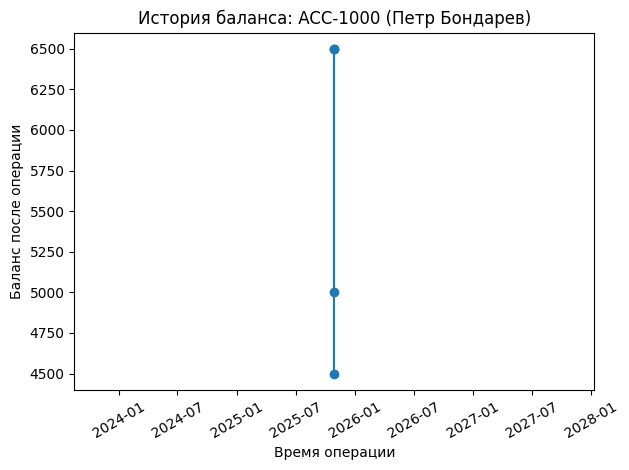

In [10]:
acc.plot_history()

In [ ]:
if __name__ == "__main__":
    # создаём аккаунты с номерами, присутствующими в образцах файлов
    csv_path = "transactions_dirty.csv"
    json_path = "transactions_dirty.json"

    acc1 = CheckingAccount("Ivan Petrov", 1000.0, account_number="ACC-100001")
    acc2 = SavingsAccount("Иван Петров", 1500.0, account_number="ACC-100002")

    for path in (csv_path, json_path):
        try:
            acc1.load_history_from_file(path)
            acc2.load_history_from_file(path)
        except FileNotFoundError:
            pass

    print(acc1, acc1.get_balance(), len(acc1.get_history()))
    print(acc2, acc2.get_balance(), len(acc2.get_history()))

<__main__.CheckingAccount object at 0x000002AFF2D2B4D0> 11498.0 39
<__main__.SavingsAccount object at 0x000002AF843F3E60> 5832.4800000000005 43
